In [157]:
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# 3. Transformaciones de intensidad y filtrado espacial 

El término *dominio espacial* se refiere al plano de la imagen en sí, y los métodos de procesamiento de imágenes de esta categoría se basan en la manipulación directa de los píxeles de una imagen. 

Esto contrasta con el procesamiento de imágenes en un dominio de transformación que implica primero transformar una imagen en el dominio de transformación, realizar el procesamiento allí y obtener la transformación inversa para devolver los resultados en el dominio espacial. 

Dos categorías principales de procesamiento espacial son las transformaciones de intensidad y el filtrado espacial. 

* Las transformaciones de intensidad operan en píxeles individuales de una imagen para tareas como manipulación de contraste y umbralización de imágenes. 

* El filtrado espacial realiza operaciones en la vecindad de cada píxel de una imagen. Ejemplos de filtrado espacial incluyen el suavizado y la nitidez de imágenes. 

## 3.1. Contexto

* Todas las técnicas de procesamiento de imágenes que veremos en esta unidad se implementan en el dominio espacial, que es el plano que contiene los píxeles de una imagen. 
* Las técnicas de dominio espacial operan directamente sobre los píxeles de una imagen

* Como verá, algunas tareas de procesamiento de imágenes son más fáciles o más significativas de implementar en el dominio espacial, mientras que otras son más adecuadas para otros enfoques.

### 3.1.1. Fundamentos de las transformaciones de intensidad y el filtrado especial

Los procesos de dominio espacial que analizamos se basan en la expresión

$$
g(x,y) = T \left[ f(x,y)\right]
$$

donde $f (x, y)$ es una imagen de entrada, $g(x, y)$ es la imagen de salida y $T$ es un operador en $f$ definido sobre una vecindad del punto $(x, y)$. 

El operador se puede aplicar a los píxeles de una sola imagen o a los píxeles de un conjunto de imágenes, como realizar la suma por elementos de una secuencia de imágenes para reducir el ruido. 

La figura muestra la implementación básica de la ecuación. 

* El punto $(x_0, y_0)$ que se muestra es una ubicación arbitraria en la imagen y la pequeña región que se muestra es una vecindad de $(x_0, y_0)$. Normalmente, la vecindad es rectangular, centrada en $(x_0, y_0)$ y de tamaño mucho más pequeño que la imagen.

* El proceso consiste en mover el centro de la vecindad de un píxel a otro y aplicar el operador $T$ a los píxeles de la vecindad para obtener un valor de salida en esa ubicación. Por lo tanto, para cualquier ubicación específica $(x_0, y_0)$, el valor de la imagen de salida $g$ en esas coordenadas es igual al resultado de aplicar $T$ a la vecindad con origen en $(x_0, y_0)$ en $f$. 



<center>
<img height=600 src='figs/filtro1.png'>

Por ejemplo, supongamos que la vecindad es un cuadrado de tamaño $3 \times 3$ y que el operador $T$ se define como “calcular la intensidad promedio de los píxeles en la vecindad”. 

Considere una ubicación arbitraria en una imagen, digamos $(100,150)$. El resultado en esa ubicación en la imagen de salida, $g(100, 150)$, es la suma de $f (100, 150)$ y sus 8 vecinos, dividida por $9$. 

Luego, el centro de la vecindad se mueve a la siguiente ubicación adyacente. y el procedimiento se repite para generar el siguiente valor de la imagen de salida $g$.

Normalmente, el proceso comienza en la parte superior izquierda de la imagen de entrada y avanza píxel a píxel en un escaneo horizontal (vertical), una fila (columna) a la vez. 

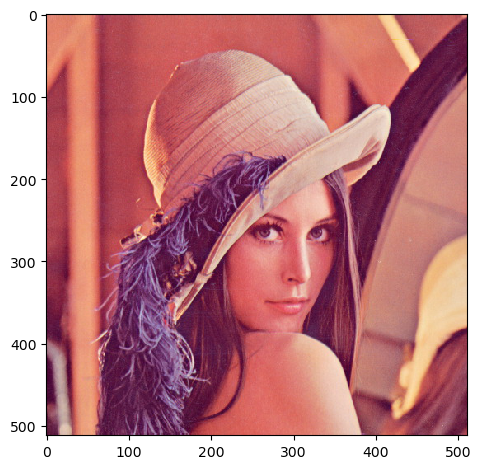

In [158]:
from skimage.io import imread, imshow

lena = imread('figs/lena.jpg')
imshow(lena)

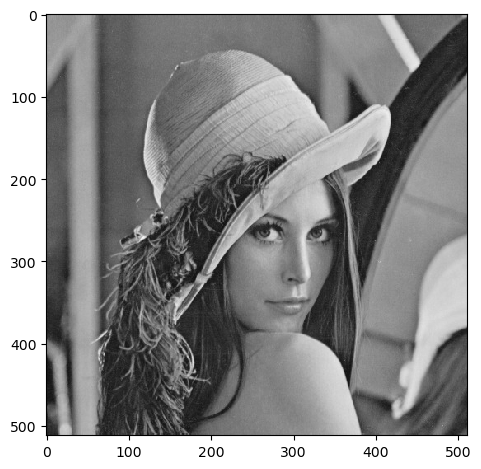

In [159]:
lena_gris = imread('figs/lena.jpg', as_gray=True)
imshow(lena_gris)

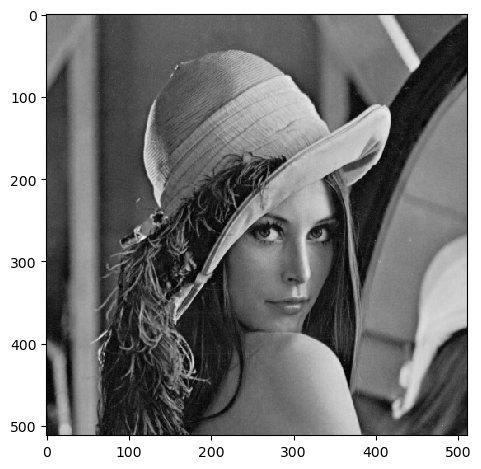

In [160]:
lena_gris = lena[:,:,1]
imshow(lena_gris)

In [161]:
import matplotlib.pyplot as plt

def show_images(*images, titles=[], cols=2, cmap='gray', figsize=(10, 10)):
    """
    Display a list of images in a grid.
    Args:
        images (list): A list of images to display.
        titles (list): A list of titles for each image (optional).
        cols (int): The number of columns in the grid (default=2).
        cmap (str): The colormap to use (default='gray').
        figsize (tuple): The size of the figure (default=(10, 10)).
    """
    rows = len(images) // cols + (1 if len(images) % cols else 0)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            if titles is not None:
                ax.set_title(titles[i] if len(titles) > i else 'Figura {}'.format(i+1))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [162]:
def aplicar_convolucion(image, kernel):
    """
    Aplica una convolución a una imagen usando un kernel.
    
    Parametros:
    image (numpy.ndarray): La imagen a convolucionar.
    kernel (numpy.ndarray): El kernel a usar.
    
    Regresa:
    numpy.ndarray: La imagen convolucionada.
    """
    # Obtenemos las dimensiones de la imagen y el kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculamos el padding
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # Creamos una imagen con padding
    padded_image = np.zeros((image_height + pad_height * 2, image_width + pad_width * 2))
    padded_image[pad_height:-pad_height, pad_width:-pad_width] = image
    
    # Creamos una imagen de salida vacía
    output_image = np.zeros_like(image)
    
    # Apply the convolution
    for y in range(pad_height, image_height + pad_height):
        for x in range(pad_width, image_width + pad_width):
            output_image[y - pad_height, x - pad_width] = np.sum(kernel * padded_image[y - pad_height:y + pad_height + 1, x - pad_width:x + pad_width + 1])
    
    return output_image


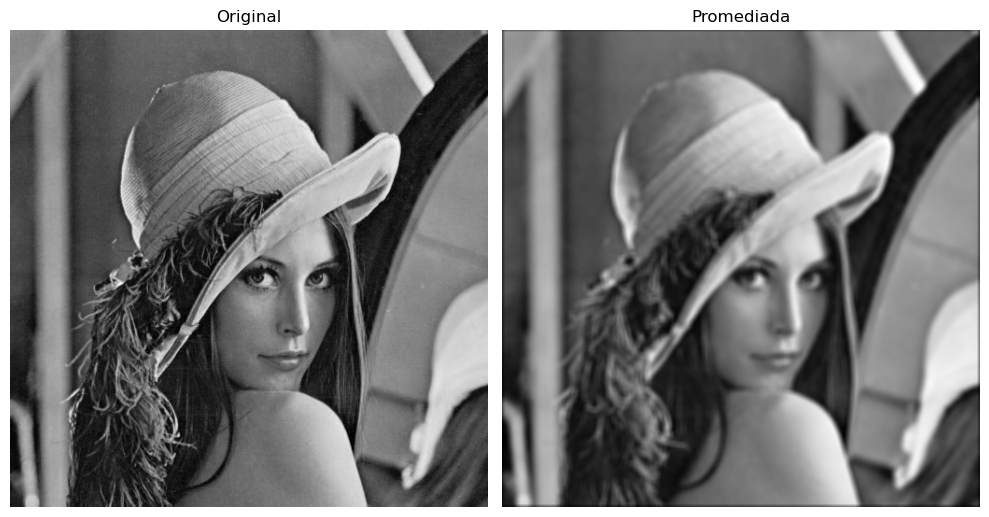

In [163]:
tam_filtro = 7
filtro_promediador = np.ones((tam_filtro, tam_filtro )) / tam_filtro**2
lena_promediada = aplicar_convolucion(lena_gris, filtro_promediador)
show_images(lena_gris, lena_promediada, titles=['Original', 'Promediada'])

## 3.2. Algunas funciones básicas de transformación de intensidad


Las transformaciones de intensidad se encuentran entre las técnicas de procesamiento de imágenes más simples. 

Denotaremos los valores de los píxeles, antes y después del procesamiento, por $r$ y $s$, respectivamente. Estos valores están relacionados mediante una transformación $T$, que asigna un valor de píxel $r$ a un valor de píxel $s$. 

Como introducción a las transformaciones de intensidad, considere la siguiente figura, que muestra tres tipos básicos de funciones utilizadas con frecuencia en el procesamiento de imágenes: 

* lineal (transformaciones negativas y de identidad), 
* logarítmica (transformaciones logarítmicas y logarítmicas inversas) y 
* ley de potencias (transformaciones enésimas y transformaciones de raíz enésima). 
* la función de identidad es el caso trivial en el que las intensidades de entrada y salida son idénticas.

<center>
<img width=600 src='figs/int_transforms1.png'>

### 3.2.1. Imágenes negativas

El negativo de una imagen con niveles de intensidad en el rango $[0, L − 1]$ se obtiene utilizando la función de transformación negativa que se muestra en la anterior, que tiene la forma:

$$
s = (L-1) - r
$$

Invertir los niveles de intensidad de una imagen digital de esta manera produce el equivalente a un negativo fotográfico. 

Este tipo de procesamiento se utiliza, por ejemplo, para mejorar los detalles blancos o grises incrustados en las regiones oscuras de una imagen, especialmente cuando las áreas negras son dominantes en tamaño. 

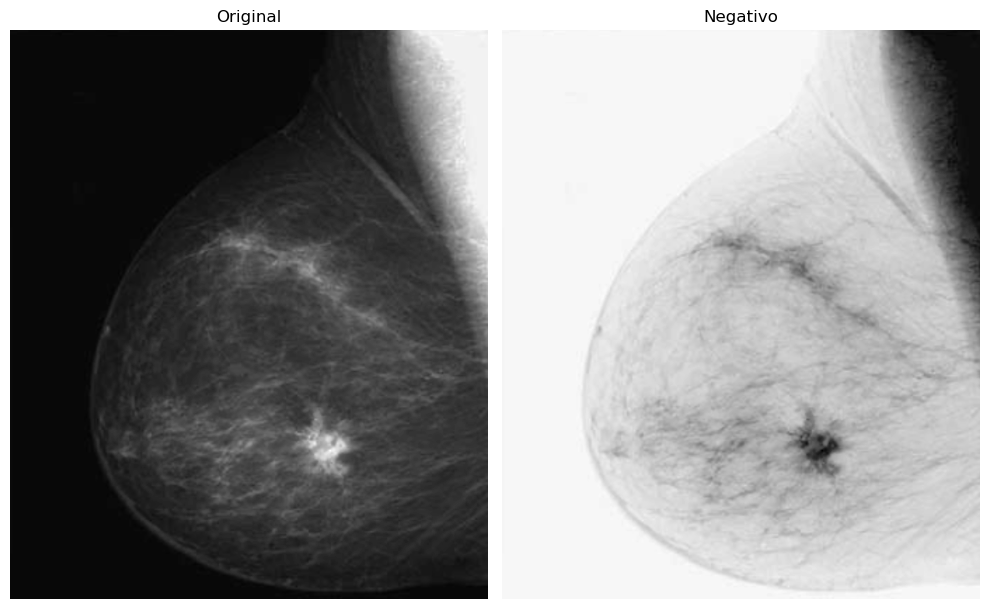

In [164]:
mast = imread('figs/mastografia1.png', as_gray=True)
max = np.max(mast)
mast_neg = max - mast

show_images(mast, mast_neg, titles=['Original', 'Negativo'])


### 3.2.2. Transformaciones logarítmicas

La forma general de la transformación logarítmica es:

$$
s = c \log (1+r)
$$

donde $c$ es una constante y se supone que $r \geq 0$. La forma de la curva logarítmica muestra que esta transformación transforma un rango estrecho de valores de baja intensidad en la entrada en un rango más amplio de niveles de salida. 

Por ejemplo, observe cómo los niveles de entrada en el rango $[0, L/4]$ se asignan a los niveles de salida en el rango $[0, 3L/4]$. 

Por el contrario, los valores más altos de los niveles de entrada se asignan a un rango más estrecho en la salida. 

Usamos una transformación de este tipo para expandir los valores de los píxeles oscuros en una imagen, mientras comprimimos los valores de nivel superior. 

Lo contrario ocurre con la transformación logarítmica inversa (exponencial).

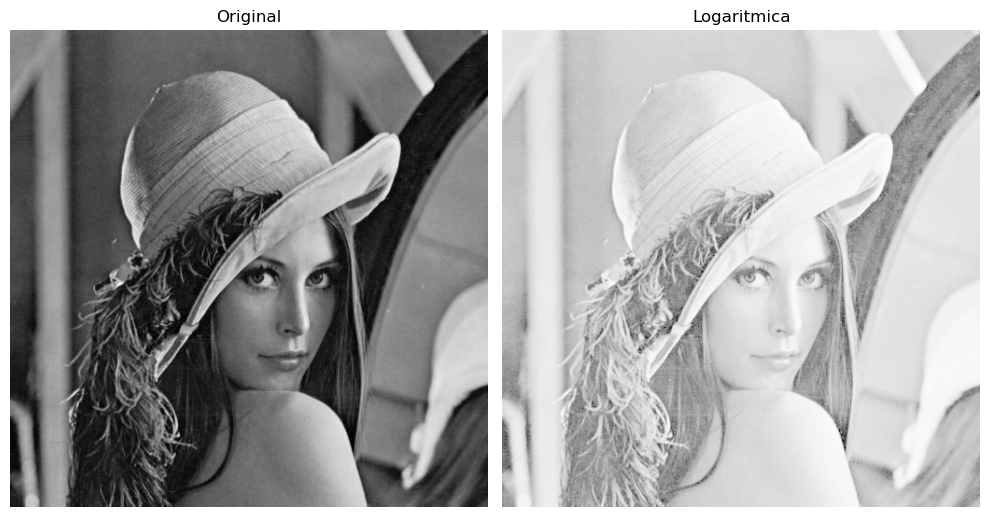

In [165]:
lena_log = np.log(1 + lena_gris)
show_images(lena_gris, lena_log, titles=['Original', 'Logaritmica'])

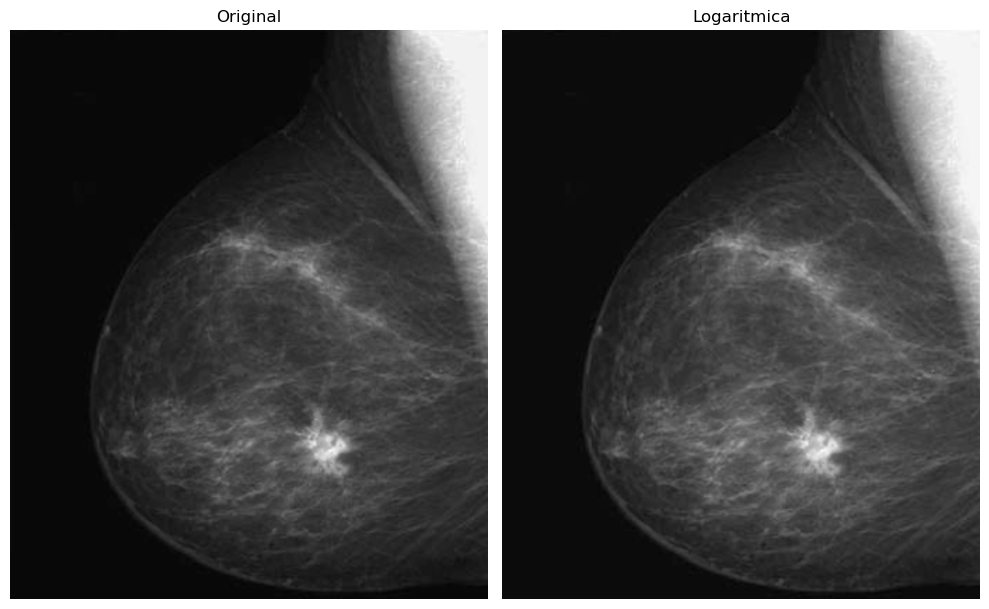

In [166]:
mast_log = np.log(1 + mast)
show_images(mast, mast_log, titles=['Original', 'Logaritmica'])

### 3.2.3. Transformaciones de ley de potencia (gamma)

Las transformaciones de ley de potencia tienen la forma:

$$
s = r^\gamma
$$

donde $c$ y $\gamma$ son constantes positivas. A veces la ecuación se escribe como $s = c (r + \epsilon)\gamma$ para tener en cuenta las compensaciones (es decir, una salida medible cuando la entrada es cero). Sin embargo, las compensaciones suelen ser una cuestión de calibración de la pantalla y, como resultado, normalmente se ignoran.

 La figura muestra gráficas de $s$ en función de $r$ para varios valores de $\gamma$. Al igual que con las transformaciones logarítmicas, las curvas de ley de potencia con valores fraccionarios de $\gamma$ asignan un rango estrecho de valores de entrada oscuros a un rango más amplio de valores de salida, y ocurre lo contrario para valores más altos de niveles de entrada. 
 
 Observe también que se puede obtener una familia de transformaciones simplemente variando $\gamma$. Las curvas generadas con valores de $\gamma > 1$  tienen exactamente el efecto opuesto a las generadas con valores de $\gamma < 1$. Cuando $c = \gamma = 1$, la ecuación se reduce a la transformación de identidad.

<center>
<img width=600 src='figs/gamma1.png'>

La respuesta de muchos dispositivos utilizados para la captura, impresión y visualización de imágenes obedece a una ley de potencia. 

Por convención, el exponente en una ecuación de ley potencial se denomina gamma. El proceso utilizado para corregir estos fenómenos de respuesta de ley de potencia se llama corrección gamma o codificación gamma.

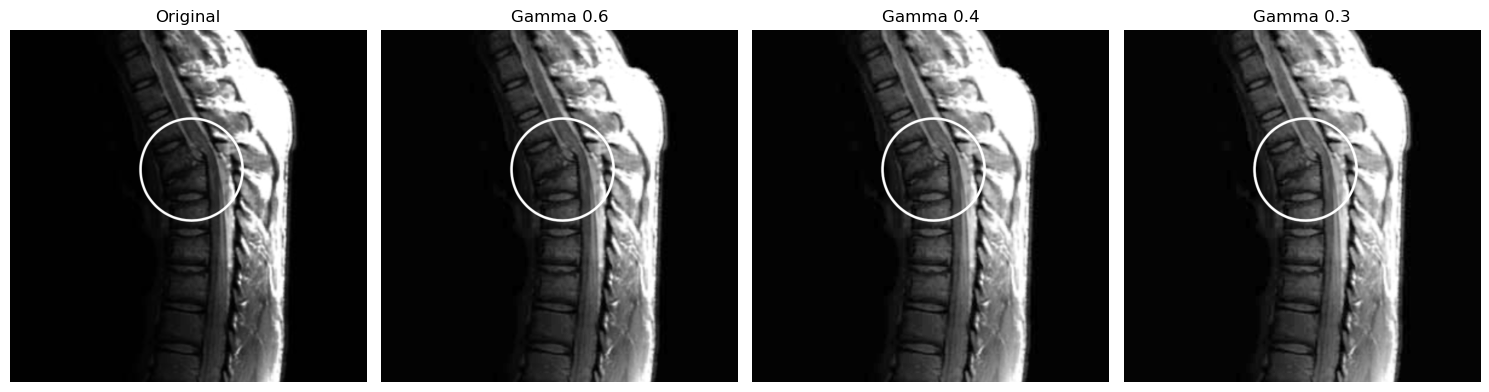

In [167]:
gamma_ex = imread('figs/gamma2.png', as_gray=True)
gamma_ex_1 = gamma_ex**0.6
gamma_ex_2 = gamma_ex**0.4
gamma_ex_3 = gamma_ex**0.3

show_images(gamma_ex, gamma_ex_1, gamma_ex_2, gamma_ex_3, 
            titles=['Original', 'Gamma 0.6', 'Gamma 0.4', 'Gamma 0.3'], 
            figsize=(15, 15), cols=4)

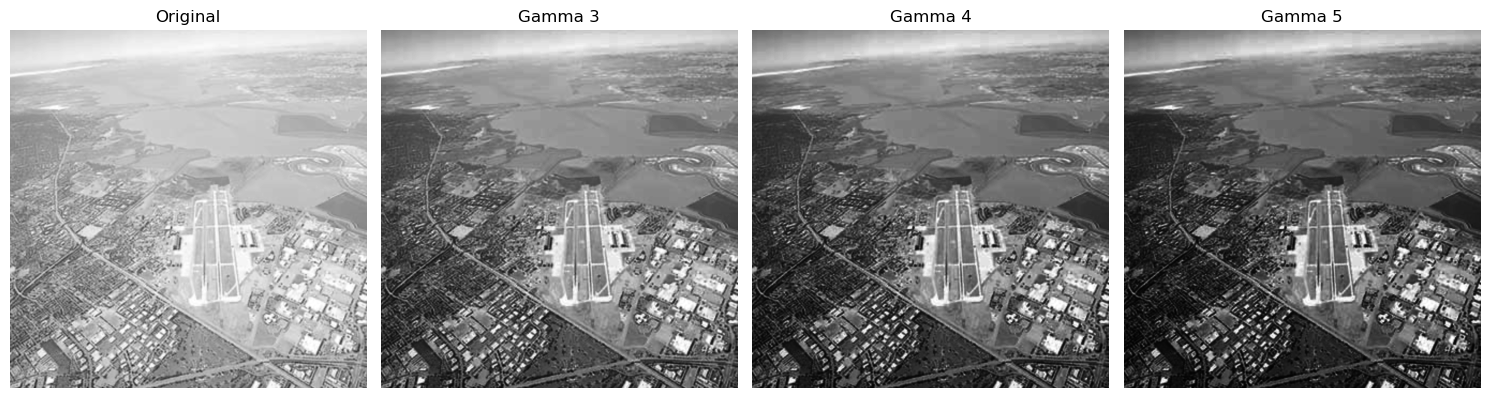

In [168]:
airport = imread('figs/gamma3.png', as_gray=True)
airport_gamma_3 = airport**3
airport_gamma_4 = airport**4
airport_gamma_5 = airport**5

show_images(airport, airport_gamma_3, airport_gamma_4, airport_gamma_5, 
            titles=['Original', 'Gamma 3', 'Gamma 4', 'Gamma 5'], 
            figsize=(15, 15), cols=4)

### 3.2.4. Transformación lineal por partes

Un enfoque complementario a los métodos analizados en las tres secciones anteriores es utilizar funciones lineales por partes. 

La ventaja de estas funciones sobre las analizadas hasta ahora es que la forma de funciones por partes puede ser arbitrariamente compleja. 

La principal desventaja de estas funciones es que su especificación requiere una considerable intervención del usuario.

#### Ajuste de contraste

Las imágenes de bajo contraste pueden deberse a una iluminación deficiente, a una falta de rango dinámico en el sensor de imágenes o incluso a una configuración incorrecta de la apertura de la lente durante la adquisición de imágenes. 

La ampliación del contraste amplía el rango de niveles de intensidad de una imagen para que abarque el rango de intensidad completo ideal del medio de grabación o dispositivo de visualización.

La figura muestra una transformación típica utilizada para el ajuste del contraste. 

Las ubicaciones de los puntos $(r_1, s_1)$ y $(r_2, s_2)$ controlan la forma de la función de transformación. 

* Si $r_1 = s_1$ y $r_2 = s_2$ la transformación es una función lineal que no produce cambios en intensidad. 

* Si $r_1 = r_2$, $s = 0$ y $s = L − 1$, la transformación se convierte en una función de umbral que crea una imagen binaria. 

* Los valores intermedios de $(r_1, s_1)$ y $(r_2, s_2)$ producen varios grados de dispersión en los niveles de intensidad de la imagen de salida, afectando así su contraste. En general, se supone r ≤ r y s ≤ s, de modo que la función tiene un solo valor y es monótonamente creciente. Esto preserva el orden de los niveles de intensidad, evitando así la creación de artefactos de intensidad. 


In [169]:
def ajustar_contraste_por_partes(image, r1, r2, s1, s2):
    """
    Ajusta el contraste de una imagen por partes.
    
    Parametros:
    image (numpy.ndarray): La imagen a ajustar.
    r1 (float): El punto de inicio de la primera parte.
    r2 (float): El punto final de la primera parte.
    s1 (float): El punto de inicio de la segunda parte.
    s2 (float): El punto final de la segunda parte.
    
    Regresa:
    numpy.ndarray: La imagen con el contraste ajustado.
    """
    # Obtenemos las dimensiones de la imagen
    image_height, image_width = image.shape
    
    # Creamos una imagen de salida vacía
    output_image = np.zeros_like(image)
    
    # Ajustamos el contraste
    for y in range(image_height):
        for x in range(image_width):
            if image[y, x] < r1:
                output_image[y, x] = s1 / r1 * image[y, x]
            elif image[y, x] < r2:
                output_image[y, x] = (s2 - s1) / (r2 - r1) * (image[y, x] - r1) + s1
            else:
                output_image[y, x] = (255 - s2) / (255 - r2) * (image[y, x] - r2) + s2
    
    return output_image

In [170]:
ajuste_contraste = imread('figs/ajuste_contraste.png')
granos = imread('figs/granos1.png', as_gray=True)
granos = granos * 255 // 1
print(np.min(granos), np.max(granos))

# esto se pone porque matplotlib ajusta el rango de la imagen
granos[0, 0] = 0
granos[0, 1] = 255

r1, s1 = 120, 20
r2, s2 = 150, 200

granos_ajustada = ajustar_contraste_por_partes(granos, r1, r2, s1, s2)
granos_binarizada = ajustar_contraste_por_partes(granos, 127, 127, 0, 255) 


106.0 147.0


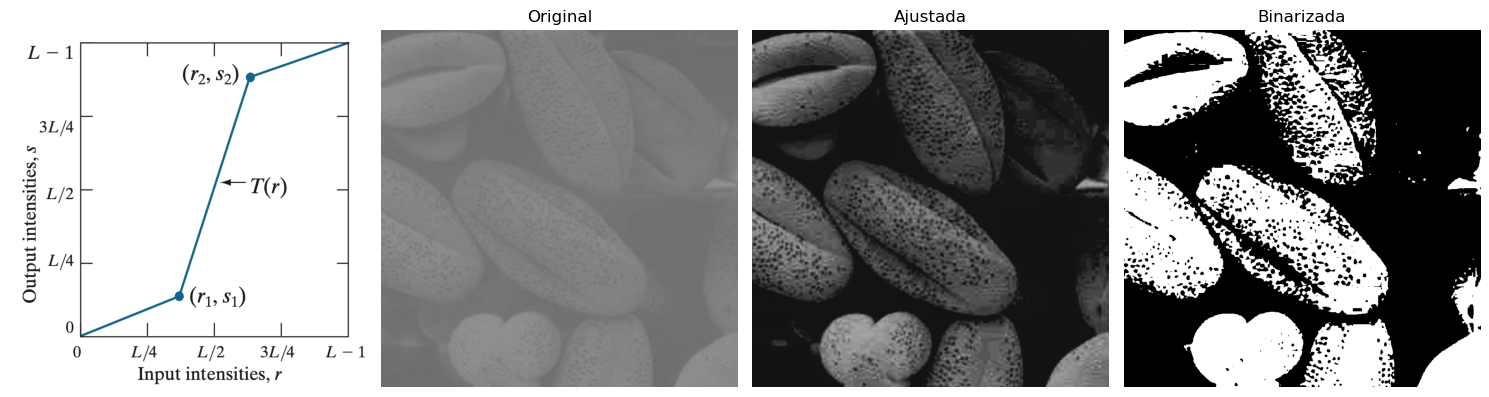

In [171]:
show_images( ajuste_contraste, granos, granos_ajustada, granos_binarizada, 
            titles=['', 'Original', 'Ajustada', 'Binarizada'], 
            figsize=(15, 15), cols=4)

#### Corte por niveles de intensidad

Hay aplicaciones en las que resulta interesante resaltar un rango concreto de intensidades en una imagen. 

Algunas de estas aplicaciones incluyen la mejora de características en imágenes de satélite, como masas de agua, y la mejora de defectos en imágenes de rayos X. 

El método, llamado corte por niveles de intensidad, se puede implementar de varias maneras, pero la mayoría son variaciones de dos temas básicos. 

* Un enfoque consiste en mostrar en un valor (digamos, blanco) todos los valores en el rango de interés y en otro (digamos, negro) todas las demás intensidades. Esta transformación produce una imagen binaria. 

* El segundo enfoque, aclara (u oscurece) el rango de intensidades deseado, pero deja todos los demás niveles de intensidad de la imagen sin cambios.

<center>
<img height=400 src='figs/rebanadas1.png'>

In [172]:
def corte_por_niveles(image, r1, r2, k1 = 1, k2 = 0):
    """
    Realiza un corte por niveles de intensidad.
    
    Parametros:
    image (numpy.ndarray): La imagen a ajustar.
    r1 (float): El punto de inicio del corte.
    r2 (float): El punto final del corte.
    k1 (float): El valor de intensidad para lo que está dentro del rango.
    k2 (float): El valor de intensidad para lo que está fuera del rango.
    
    Regresa:
    numpy.ndarray: La imagen con el corte aplicado.
    """
    # Obtenemos las dimensiones de la imagen
    image_height, image_width = image.shape
    
    # Creamos una imagen de salida vacía
    output_image = np.zeros_like(image)
    
    # Ajustamos el contraste
    for y in range(image_height):
        for x in range(image_width):
            if r1 <= image[y, x] <= r2:
                val = k1 * image[y, x]
                output_image[y, x] = val if val <= 255 else 255
            else:
                output_image[y, x] = k2 * image[y, x]
    
    return output_image

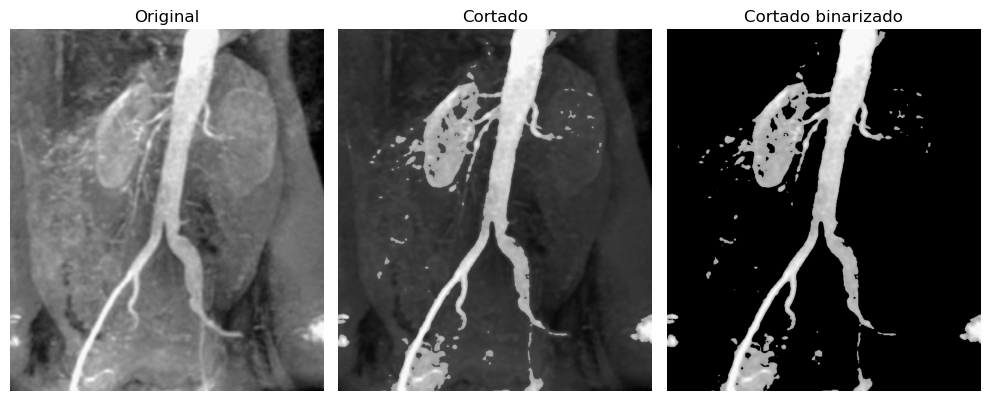

In [173]:
angiograma = imread('figs/angiograma.png', as_gray=True)
angiograma = angiograma * 255 // 1

angiograma_cortado_bin = corte_por_niveles(angiograma, 150, 255)
angiograma_cortado = corte_por_niveles(angiograma, 150, 255, 1, 0.5)

show_images(angiograma, angiograma_cortado, angiograma_cortado_bin,
            titles=['Original', 'Cortado', 'Cortado binarizado'], 
            cols=3)

#### Corte de plano de bits

Los valores de píxeles son números enteros compuestos de bits. Por ejemplo, los valores de una imagen en escala de grises de 256 niveles se componen de 8 bits (un byte). 

En lugar de resaltar los rangos de niveles de intensidad, podríamos resaltar la contribución realizada por bits específicos a la apariencia total de la imagen. Como ilustra la figura, se puede considerar que una imagen de 8 bits está compuesta por ocho planos de un bit: 

* el plano 1 contiene el bit de orden más bajo de todos los píxeles de la imagen y 
* el plano 8 contiene todos los bits de orden más alto.

<center>
<img height=400 src='figs/bit_slicing.png'>

A continuación se muestra una imagen en escala de grises de 8 bits y sus ocho planos de un bit, correspondiendo.

* Observe que los cuatro planos de bits de orden superior, especialmente los dos primeros, contienen una cantidad significativa de datos visualmente significativos. 

* Los planos de orden inferior contribuyen a detalles de intensidad más sutiles en la imagen. 


In [174]:
dollar = imread('figs/dollar.png', as_gray=True)
dollar = dollar * 255 // 1
dollar = dollar.astype(np.uint8)

dollar8 = dollar & 0x80
dollar7 = dollar & 0x40
dollar6 = dollar & 0x20
dollar5 = dollar & 0x10
dollar4 = dollar & 0x08
dollar3 = dollar & 0x04
dollar2 = dollar & 0x02
dollar1 = dollar & 0x01

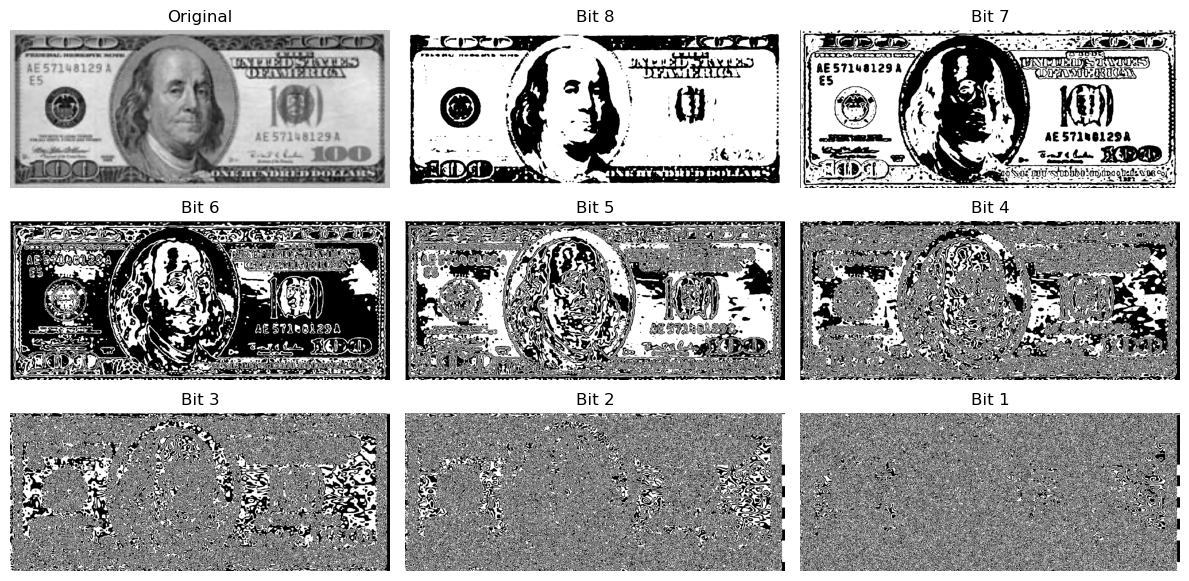

In [175]:
show_images(dollar, dollar8, dollar7, dollar6, dollar5, dollar4, dollar3, dollar2, dollar1,
            titles=['Original', 'Bit 8', 'Bit 7', 'Bit 6', 'Bit 5', 'Bit 4', 'Bit 3', 'Bit 2', 'Bit 1'], 
            cols=3, 
            figsize=(12, 6))

Descomponer una imagen en sus planos de bits es útil para analizar la importancia relativa de cada bit en la imagen, un proceso que ayuda a determinar la idoneidad del número de bits utilizados para cuantificar la imagen. 

Además, este tipo de descomposición es útil para la compresión de imágenes, en la que se utilizan menos de todos los planos para reconstruir una imagen. 


Por ejemplo, a continuación se muestra una imagen reconstruida utilizando los planos de bits 8-7, 8-7-6 y 8-7-6-5 de la descomposición anterior. 

* Aunque se restauraron las características principales de la imagen original, la imagen reconstruida parece plana, especialmente en el fondo. Esto no es sorprendente, porque dos planos sólo pueden producir cuatro niveles de intensidad distintos. 

* Agregar el plano 6 a la reconstrucción ayudó a mejorar la situación. Tenga en cuenta que el fondo de esta imagen tiene un contorno falso perceptible. 

* Este efecto se reduce significativamente al agregar el quinto plano a la reconstrucción. Usar más planos en la reconstrucción no contribuiría significativamente a la apariencia de esta imagen. 

* En este ejemplo, almacenar los cuatro planos de bits de orden más alto nos permitiría reconstruir la imagen original con un detalle aceptable. Almacenar estos cuatro planos en lugar de la imagen original requiere un 50% menos de almacenamiento.

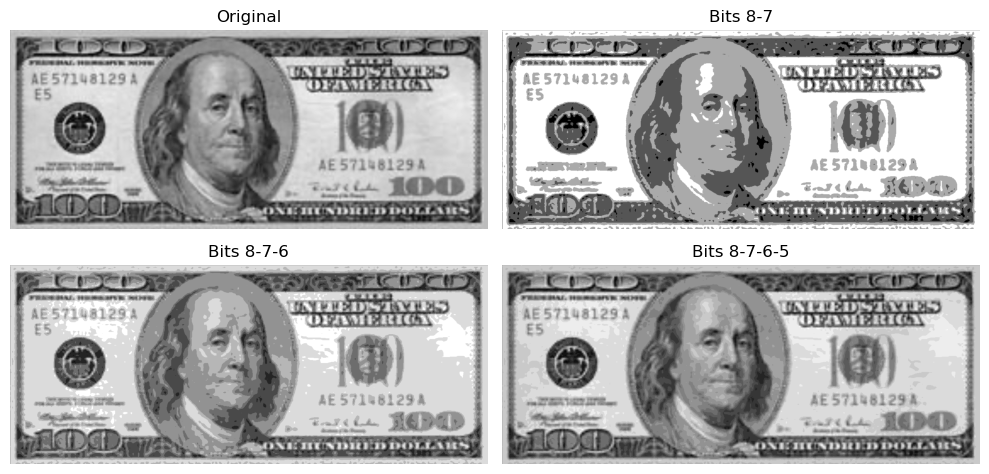

In [176]:
dollar87 = dollar8 | dollar7
dollar876 = dollar87 | dollar6
dollar8765 = dollar876 | dollar5

show_images(dollar, dollar87, dollar876, dollar8765,    
            titles=['Original', 'Bits 8-7', 'Bits 8-7-6', 'Bits 8-7-6-5'], 
            cols=2, 
            figsize=(10, 5))

## 3.3. Procesamiento de histogramas

Sea $r_k$, para $k = 0,1,2,...,L−1$, las intensidades de una imagen digital de $L$ niveles, $f (x, y)$. El histograma no normalizado de $f$ se define como:

$$
h(r_k) = n_k, k=1,2,\dots,L-1
$$

donde $n_k$ es el número de píxeles en $f$ con intensidad $r_k$ y las subdivisiones de la escala de intensidad se denominan contenedores de histograma. 

De manera similar, el histograma normalizado de $f$ se define como:

$$
p(r_k) = \frac{h(r_k)}{MN}=\frac{n_k}{MN}
$$

donde, como es habitual, $M$ y $N$ son el número de filas y columnas de la imagen, respectivamente. 

* Principalmente, trabajamos con histogramas normalizados, a los que nos referimos simplemente como histogramas o histogramas de imágenes. 

* La suma de $p(r_k)$ para todos los valores de $k$ es siempre $1$. 

* Los componentes de $p(r_k)$ son estimaciones de las probabilidades de que se produzcan niveles de intensidad en una imagen. 


In [177]:
def histograma(image):
    """
    Calcula el histograma de una imagen.
    
    Parametros:
    image (numpy.ndarray): La imagen a calcular el histograma.
    
    Regresa:
    numpy.ndarray: El histograma de la imagen.
    """
    # Obtenemos las dimensiones de la imagen
    image_height, image_width = image.shape
    
    # Creamos un arreglo para el histograma
    hist = np.zeros(256)
    
    # Calculamos el histograma
    for y in range(image_height):
        for x in range(image_width):
            hist[int(image[y, x])] += 1

    for i in range(256):
        hist[i] /= image_height * image_width
    
    return hist


<BarContainer object of 256 artists>

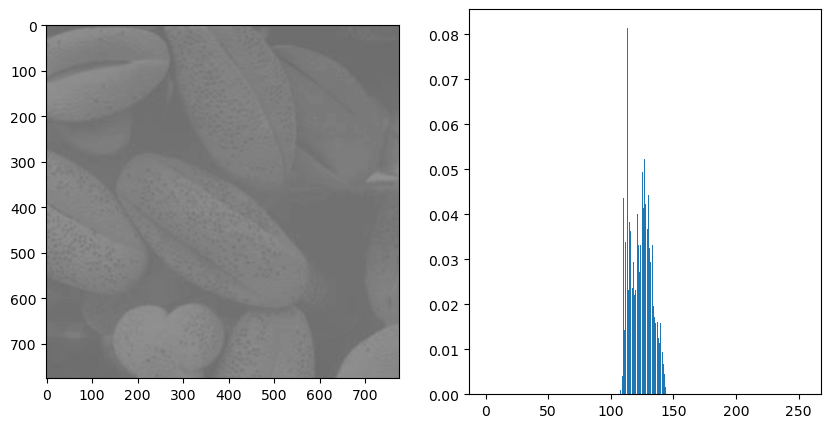

In [178]:
granos_hist = histograma(granos)

plt.subplots(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(granos, cmap='gray')
plt.subplot(1, 2, 2)
plt.bar(np.arange(256), granos_hist)

<BarContainer object of 256 artists>

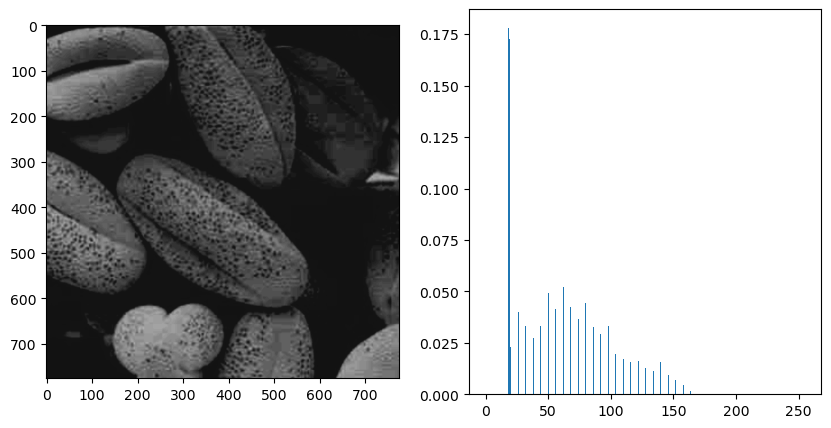

In [179]:
granos_ajustada_hist = histograma(granos_ajustada)

plt.subplots(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(granos_ajustada, cmap='gray')
plt.subplot(1, 2, 2)
plt.bar(np.arange(256), granos_ajustada_hist)

<BarContainer object of 256 artists>

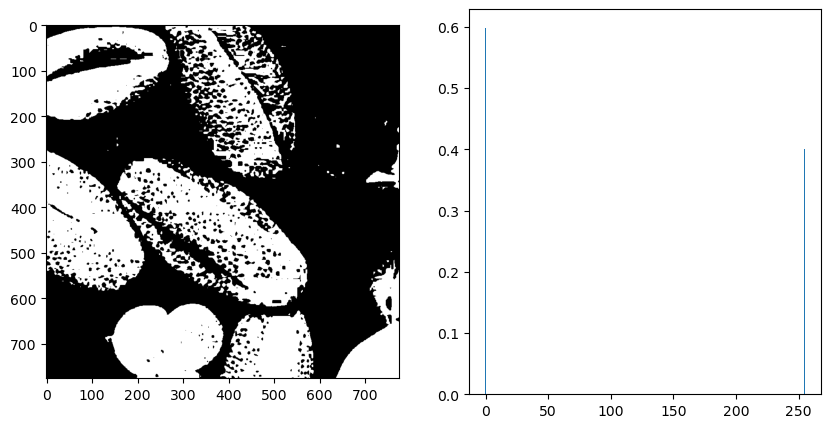

In [180]:
granos_binarizada_hist = histograma(granos_binarizada)

plt.subplots(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(granos_binarizada, cmap='gray')
plt.subplot(1, 2, 2)
plt.bar(np.arange(256), granos_binarizada_hist)

### 3.3.1. Ecualización del histograma

Suponiendo valores de intensidad inicialmente continuos, sea la variable $r$ la que denota las intensidades de una imagen a procesar. 

Como es habitual, suponemos que $r$ está en el rango $[0, L − 1]$, donde $r = 0$ representa el negro y $r = L − 1$ representa el blanco. 

Para que $r$ satisfaga estas condiciones, centramos la atención en transformaciones (mapeos de intensidad) de la forma:

$$
s = T(r), 0 \leq r \leq N-1 
$$

que producen un valor de intensidad de salida $s$, para un valor de intensidad dado $r$ en la imagen de entrada. Asumimos que

1. $T(r)$ es una función monótona creciente en el intervalo $0 \leq r \leq L − 1$; y
2. $ 0 \leq T(r) \leq L-1 $ para $ 0 \leq r \leq L-1 $.

> **NOTA:** Una función $T(r)$ es una función monótona creciente si $T(r_1) \geq T(r_2)$ para $r_1 > r_2$. $T(r)$ es una función creciente estrictamente monótona si $T(r_1) > T(r_2)$ para $r_1 > r_2$. Se aplican definiciones similares a una función decreciente monótona.


En algunas formulaciones que se analizarán en breve, utilizamos la transformación inversa:

$$
r =T^{-1}(s), 0 \leq s \leq L-1
$$

en cuyo caso cambiamos la condición (a) a:

3. $T(r)$ es una función creciente estrictamente monótona en el intervalo $0 \leq  r \leq L − 1$.

La condición en (1) de que $T(r)$ aumente monótonamente garantiza que los valores de intensidad de salida nunca serán menores que los valores de entrada correspondientes, evitando así artefactos creados por inversiones de intensidad. 

La condición (2) garantiza que el rango de intensidades de salida es el mismo que el de entrada. 

Finalmente, la condición (a) garantiza que las asignaciones desde $s$ hasta $r$ serán uno a uno, evitando así ambigüedades.

<center>
<img height=400 src='figs/monotonic.png'>

La intensidad de una imagen puede verse como una variable aleatoria en el intervalo $[0,L − 1]$. Sean $p_r(r)$ y $p_s(s)$ las funciones de distribución de probabilidad (PDF - *probability distribution function*) de los valores de intensidad $r$ y $s$ en dos imágenes diferentes. Los subíndices de $p$ indican que $p_r$ y $p_s$ son funciones diferentes. 

Un resultado fundamental de la teoría de la probabilidad es que si $p_r (r)$ y $T(r)$ son conocidos, y $T(r)$ es continua y diferenciable en el rango de valores de interés, entonces la distribución de probabilidad de la variable transformada (mapeada) $s$ puede ser obtenido como:

$$
p_s(s) = p_r(r) \left| \frac{ds}{dr} \right|
$$

Así, vemos que la PDF de la variable de intensidad de salida, $s$, está determinada por la PDF de las intensidades de entrada y la función de transformación utilizada [recordemos que r y s están relacionados por T(r)].
Una función de transformación de particular importancia en el procesamiento de imágenes es

$$
s = T(r) = (L-1)\int _0 ^r p_r(w)dw
$$

donde $w$ es una variable ficticia de integración. La integral del lado derecho es la función de distribución acumulativa (CDF - *cumulative distribution function*) de la variable aleatoria $r$. 

Debido a que las PDF siempre son positivas y la integral de una función es el área bajo la función, el área bajo la función no puede disminuir a medida que $r$ aumenta. 

Cuando el límite superior de esta ecuación es r = (L − 1), la integral se evalúa como 1, como debe ser para una PDF. 

Sabemos por la regla de Leibniz en cálculo que la derivada de una integral definida con respecto a su límite superior es el integrando evaluado en el límite. Eso es:

$$
\frac{ds}{dr} = \frac{dT(r)}{dr} = (L-1)\frac{d}{dr}\left[ \int _0 ^r p_r(w)d(w) \right] = (L-1)p_r(r)
$$


Sustituyendo este resultado por $dr / ds$, y observando que todos los valores de probabilidad son positivos, se obtiene 

$$
p_s(s) = p_r(r)\left| \frac{dr}{ds} \right| = p_r(r) \left| \frac{1}{(L-1)p_r(r)} \right| = \frac{1}{L-1}
$$

<center>
<img width=800 src='figs/pdfs.png'>

Para valores discretos, trabajamos con probabilidades y sumatorias en lugar de funciones de densidad de probabilidad e integrales. 

Recuerde que la probabilidad de ocurrencia del nivel de intensidad rk en una imagen digital se aproxima por:

$$
p_r(r_k) = \frac{n_k}{MN}
$$

donde $M$ y $N$ son el número total de píxeles en la imagen, y $n_k$ denota el número de píxeles que tienen intensidad $r_k$.

La transformación en su forma discreta será:

$$
s_k = T(r_k) = (L-1)\sum _{j=0} ^k p_r(r_j), k = 1, 2, \dots, L-1
$$

donde, $L$ es el número de niveles de intensidad posibles en la imagen (por ejemplo, 256 para una imagen de 8 bits). 

Se obtiene una imagen procesada (de salida) utilizando la ecuación anterior para asignar cada píxel de la imagen de entrada con intensidad $r_k$ a un píxel correspondiente con nivel $s_k$ en la imagen de salida. Esto se denomina *ecualización de histograma*.

In [181]:
def ecualizar_histograma(image):
    """
    Ecualiza el histograma de una imagen.
    
    Parametros:
    image (numpy.ndarray): La imagen a ecualizar.
    
    Regresa:
    numpy.ndarray: La imagen con el histograma ecualizado.
    """
    # Obtenemos las dimensiones de la imagen
    image_height, image_width = image.shape
    
    # Calculamos el histograma
    hist = histograma(image)
    
    # Calculamos la función de distribución acumulada
    cdf = np.zeros(256)
    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + hist[i]
    
    # Calculamos la ecualización
    ecualizada = np.zeros_like(image)
    for y in range(image_height):
        for x in range(image_width):
            ecualizada[y, x] = cdf[image[y, x]] * 255
    
    return ecualizada

In [186]:
def plot_images_hist(imagen, ecualizada, histograma):
    plt.subplots(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(imagen, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(ecualizada, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.bar(np.arange(256), histograma)


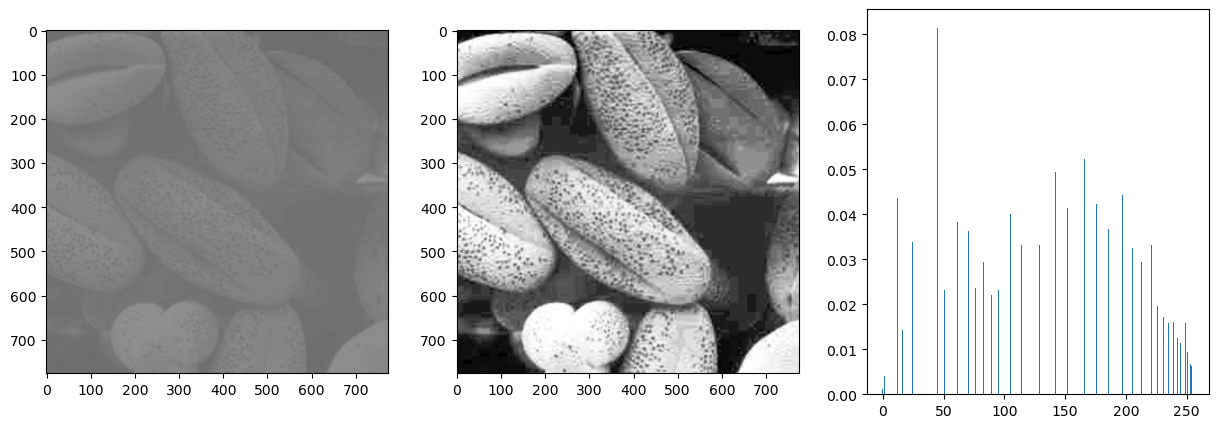

In [187]:
# granos = granos * 255 // 1
granos = granos.astype(np.uint8)
granos_ecualizada = ecualizar_histograma(granos)
granos_ecualizada_hist = histograma(granos_ecualizada)

plot_images_hist(granos, granos_ecualizada, granos_ecualizada_hist)

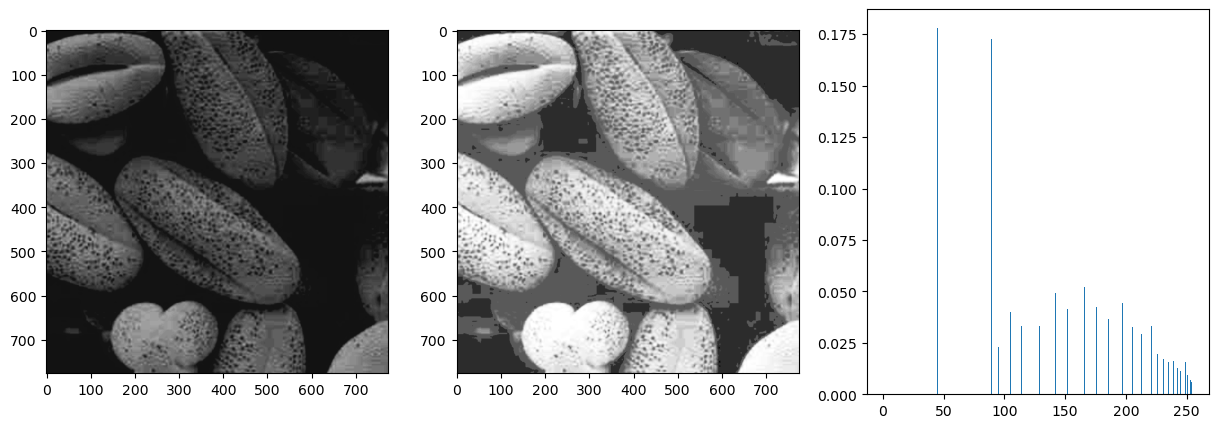

In [188]:
granos_ajustada = ajustar_contraste_por_partes(granos, r1, r2, s1, s2)
granos_ajustada = granos_ajustada.astype(np.uint8)
granos_ajustada_ecualizada = ecualizar_histograma(granos_ajustada)
granos_ajustada_ecualizada_hist = histograma(granos_ajustada_ecualizada)

plot_images_hist(granos_ajustada, granos_ajustada_ecualizada, granos_ajustada_ecualizada_hist)

## 3.4. Fundamentos del filtrado espacial

El filtrado espacial se utiliza en un amplio espectro de aplicaciones de procesamiento de imágenes, por lo que es importante tener una comprensión sólida de los principios de filtrado. 

El nombre filtro se toma prestado del procesamiento en el dominio de la frecuencia, donde “filtrado” se refiere a pasar, modificar o rechazar componentes de frecuencia específicos de una imagen. 

* Por ejemplo, un filtro que pasa bajas frecuencias se llama filtro de paso-bajo. 
* El efecto neto producido por un filtro de paso bajo es suavizar una imagen difuminándola. 
* Podemos lograr un suavizado similar directamente en la imagen mediante el uso de filtros espaciales.

### 3.4.1. La mecánica del filtrado espacial

Un filtro espacial lineal realiza una operación de suma de productos entre una imagen $f$ y un núcleo de filtro $w$. 
* El núcleo es una matriz cuyo tamaño define la vecindad de operación y cuyos coeficientes determinan la naturaleza del filtro. 
* Otros términos utilizados para referirse a un núcleo de filtro espacial son máscara, plantilla y ventana. 
* Usamos el término kernel de filtro o simplemente kernel.



<center>
<img width=600 src='figs/kernel1.png'>


En cualquier punto (x, y) de la imagen, la respuesta, g(x, y), del filtro es la suma de los productos de los coeficientes del núcleo y los píxeles de la imagen abarcados por el núcleo:

$$
g(x,y) = w(-1,-1)f(x-1,y-1) + w(-1,0)f(x-1,y) + \dots + w(0,0)f(x,y) + \dots + w(1,1)f(x+1,y+1)
$$

Observe que el coeficiente central del núcleo, $w(0, 0)$, se alinea con el píxel en la ubicación $(x, y)$. 

Para un núcleo de tamaño $m \times n$, asumimos que $m = 2a + 1$ y $n = 2b + 1$, donde $a$ y $b$ son números enteros no negativos. 
* Esto significa que nos centramos en núcleos de tamaño impar en ambas direcciones de coordenadas. 

En general, el filtrado espacial lineal de una imagen de tamaño M × N con un núcleo de tamaño m × n viene dado por la expresión:

$$
g(x,y) = \sum _{s=-a} ^a \sum _{t=-b}^b w(s,t)f(x+s, y+t)
$$

donde $x$ e $y$ varían de modo que el centro (origen) del núcleo visita cada píxel en $f$ una vez.

Para un valor fijo de $(x, y)$, se define implementa la suma de productos de la forma que se muestra en la ecuación, pero para un núcleo de tamaño impar arbitrario. 

### 3.4.2. Correlación y convolución espacial

La correlación espacial se ilustró gráficamente en la figura previa y se describe matemáticamente mediante la ecuación anterior. La correlación consiste en mover el centro de un núcleo sobre una imagen y calcular la suma de productos en cada ubicación. 

La mecánica de la convolución espacial es la misma, excepto que el núcleo de correlación se gira 180°. 

Así, cuando los valores de un núcleo son simétricos respecto de su centro, la correlación y la convolución producen el mismo resultado. 


La correlación de un núcleo $w$ de tamaño $m \times n$ con una imagen $f (x, y)$, denotada como $(w \star f )(x, y)$, viene dada por la ecuación:

$$
(w \star f)(x,y) = \sum _{s=-a} ^a \sum _{t=-b}^b w(s,t)f(x+s, y+t)
$$

De manera similar, la convolución de un núcleo $w$ de tamaño $m \times n$ con una imagen $f (x, y)$, denotada por $(w \bigstar f )(x, y)$, se define como:

$$
(w \bigstar f)(x,y) = \sum _{s=-a} ^a \sum _{t=-b}^b w(s,t)f(x-s, y-t)
$$

donde los signos menos alinean las coordenadas de $f$ y $w$ cuando una de las funciones se gira 180°.

Debido a que la convolución es conmutativa, es irrelevante si se rota $w$ o $f$, pero la rotación del núcleo se usa por convención. 

<center>

| Propiedad | Convolución | Correlación |
|---|:---:|:---:|
| Conmutativa| $$ f \bigstar g = g \bigstar f $$ | - |
| Asociativa | $$ f \bigstar (g \bigstar h) = (f \bigstar g) \bigstar h $$ | - |
| Distributiva | $$ f \bigstar (g + h) = (f \bigstar g) + (f \bigstar h) $$ | $$ f \star (g + h) = (f \star g) + (f \star h) $$ |


Nuestros núcleos no dependen de $(x,y)$, un hecho que a veces hacemos explícito escribiendo el lado izquierdo de la ecuación como $w \bigstar f (x, y)$. 

A veces, una imagen se filtra (es decir, se convoluciona) secuencialmente, en etapas, utilizando un núcleo diferente en cada etapa. 

* Por ejemplo, supongamos que una imagen $f$ se filtra con un kernel $w_1$, el resultado se filtra con un kernel $w_2$, ese resultado se filtra con un tercer kernel, y así sucesivamente, para $Q$ etapas. 
* Debido a la propiedad conmutativa de la convolución, este filtrado de varias etapas se puede realizar en una única operación de filtrado, $w \bigstar f$ , donde:

$$
w = w_1 \bigstar w_2 \bigstar w_3 \bigstar \dots \bigstar w_Q 
$$

* El tamaño de $w$ se obtiene a partir de los tamaños de los núcleos individuales mediante aplicaciones sucesivas de estos. 

* Si todos los núcleos individuales son de tamaño $m \times n$, de estas ecuaciones se deduce que $w$ será de tamaño $W_v × W_h$, donde:

$$
W_v = Q(m-1) + m
$$

$$
W_h = Q(n-1) + n
$$

### 3.4.3. Sobre cómo se construyen los núcleos



Consideramos tres enfoques básicos para construir filtros espaciales. 

* Un enfoque se basa en formular filtros basados en propiedades matemáticas. 
    * Por ejemplo, un filtro que calcula el promedio de píxeles en un vecindario desenfoca una imagen. Calcular un promedio es análogo a la integración. 

* Un segundo enfoque se basa en muestrear una función espacial bidimensional cuya forma tiene una propiedad deseada. 
    * Por ejemplo, se pueden usar muestras de una función gaussiana para construir un filtro de promedio ponderado (paso bajo). 

* Un tercer enfoque consiste en diseñar un filtro espacial con una respuesta de frecuencia específica. Ilustraremos estas técnicas en la Sección 3.7.

## 3.5. Filtros espaciales de suavizado (pasa bajo)

Los filtros espaciales de suavizado (también llamados promedio) se utilizan para reducir las transiciones bruscas de intensidad. 
* Debido a que el ruido aleatorio normalmente consiste en transiciones bruscas de intensidad, una aplicación obvia del suavizado es la reducción de ruido. 
* El suavizado se utiliza para reducir los detalles irrelevantes en una imagen, donde "irrelevante" se refiere a regiones de píxeles que son pequeñas con respecto al tamaño del núcleo del filtro. 
* Otra aplicación es suavizar los contornos falsos que resultan del uso de un número insuficiente de niveles de intensidad en una imagen. 



Los filtros de suavizado se utilizan en combinación con otras técnicas para mejorar la imagen, como las técnicas de procesamiento de histogramas analizadas previamente, y el enmascaramiento de enfoque. 

Como comentamos, el filtrado espacial lineal consiste en convolucionar una imagen con un núcleo de filtro. 
* La convolución de un núcleo de suavizado con una imagen desenfoca la imagen, y el grado de desenfoque está determinado por el tamaño del núcleo y los valores de sus coeficientes. 
* Además de ser útiles en innumerables aplicaciones de procesamiento de imágenes, los filtros de paso bajo son fundamentales, en el sentido de que otros filtros importantes, incluidos los filtros de nitidez (paso alto), paso de banda y rechazo de banda, pueden derivarse de filtros de paso bajo.


## 3.6. Filtros espaciales de nitidez (pasa alto)

## 3.7. Filtros de pasa alto, rechazo de banda y pasa de banda a partir de filtros de pasa bajo

## 3.8. Combinación de métodos de mejora espacial